# Notebook Setup

In [ ]:
!apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
%pip install -U tf-agents pyvirtualdisplay
%pip install -U gym>=0.21.0
%pip install -U gym[box2d,atari,accept-rom-license]

In [1]:
# Import Libraries

# TensorFlow
import tensorflow as tf
from tensorflow import keras

# Maths
import numpy as np
import matplotlib.pyplot as plt

# Gym
import gym

# Virtual Display
# import pyvirtualdisplay

# Common 
import os
import sys

# Saving
import pickle

# Other
from collections import deque

C:\Users\Cael Milne\AppData\Local\Programs\Python\Python37\lib\site-packages\ale_py\roms\utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [2]:
# Global Variables
PROJECT_ROOT_DIR = 'drive/MyDrive/ML/Keras_Version/Hybrid'

# SEEDS
np.random.seed(69)
tf.random.set_seed(420)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Helper Functions

In [3]:
# Pre-Processing
def preprocess_observation(observation):

    # Slice Top Off
    img = observation[14:210:2, ::2]

    # Grey Scale
    img = img.mean(axis=2)
    img = (img - 128).astype(np.float32)

    return img.reshape(98, 80, 1)

In [116]:
# Epsilon Greedy Policy
def epsilon_greedy_policy_hybrid(ram, img, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict([img.reshape(1, 98, 80, 1), ram.reshape(1, 128)])
        return np.argmax(Q_values[0])

In [75]:
# Sample Experiences
def sample_experiences(batch_size):
    indices = np.random.randint(len(REPLAY_MEMORY), size=batch_size)
    batch = [REPLAY_MEMORY[index] for index in indices]
    ram, img, actions, rewards, next_state_img, next_state_ram, dones = [np.array([experience[field_index] for experience in batch]) for field_index in range(7)]
    return ram, img, actions, rewards, next_state_img, next_state_ram, dones

In [76]:
# One Iteration
def playHybrid(env, ram, img, epsilon, frame_skip):

    # Get Action
    action = epsilon_greedy_policy_hybrid(ram, img, epsilon)

    # Do Action frame_skip Times
    iter_reward = 0
    for frame in range(frame_skip):
        next_state_img, reward, done, info = env.step(action)
        iter_reward += reward


    next_state_img = preprocess_observation(next_state_img)
    next_state_ram = env.ale.getRAM()

    # Add Last Frame to Buffer
    REPLAY_MEMORY.append((ram, img, action, iter_reward, next_state_img, next_state_ram, done))
    return next_state_img, next_state_ram, iter_reward, done, info

In [107]:
# Config
batch_size = 32
discount_rate = 0.99
learning_rate = 0.00025
momentum = 0.95
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)
loss_fn = keras.losses.mean_squared_error

# Train from Memory
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    ram, img, actions, rewards, next_state_img, next_state_ram, dones = experiences

    next_Q_values = model.predict([next_state_img, next_state_ram])

    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values).reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)

    with tf.GradientTape() as tape:
        all_Q_values = model([next_state_img, next_state_ram])
        Q_values = tf.reduce_sum(all_Q_values * mask, axis = 1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

# Q-Learning with Frames

In [108]:
# Create Environment
keras.backend.clear_session()

env = gym.make("AssaultNoFrameskip-v4")

env.reset()
exampleRamInput = env.ale.getRAM()

input_shape_img = (98, 80, 1)
input_shape_ram = (128)
n_outputs = env.action_space.n

initializer = keras.initializers.VarianceScaling()

def buildModel():
    inputImg = keras.layers.Input(shape=(98, 80, 1))
    # inputImgReshape = keras.layers.Reshape((98, 80, 1))(inputImg)

    inputRam = keras.layers.Input(shape=(128, ))
    # inputRamReshape = keras.layers.Reshape((128,), input_shape=(1,))(inputRam)

    imgMod = keras.layers.Conv2D(filters=32, kernel_size=8, strides=4, padding="same", activation="relu", kernel_initializer=initializer)(inputImg)
    imgMod = keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding="same", activation="relu", kernel_initializer=initializer)(imgMod)
    imgMod = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu", kernel_initializer=initializer)(imgMod)
    imgMod = keras.layers.Flatten()(imgMod)
    imgMod = keras.layers.Dense(units=128, activation="relu", kernel_initializer=initializer)(imgMod)
    imgMod = keras.Model(inputs=inputImg, outputs=imgMod)

    ramMod = keras.layers.Dense(128, activation="relu", kernel_initializer=initializer)(inputRam)
    ramMod = keras.Model(inputs=inputRam, outputs=ramMod)

    merged = keras.layers.concatenate([imgMod.output, ramMod.output])

    combMod = keras.layers.Dense(units=640, activation="relu", kernel_initializer=initializer)(merged)
    combMod = keras.layers.Dense(units=512, activation="relu", kernel_initializer=initializer)(combMod)
    combMod = keras.layers.Dense(n_outputs, activation="relu", kernel_initializer=initializer)(combMod)
    combMod = keras.Model(inputs=[imgMod.input, ramMod.input], outputs=combMod)
    return combMod

model = buildModel()

In [117]:
# Train Convolutional Model

# CONFIG
env.seed(710)
REPLAY_MEMORY = deque(maxlen=100)
FRAMESKIP = 4
EPISODES = 1000
STEPS = 1000000
WARMUP = 35


episode_rewards = []
best_score = 0

step = 0
for episode in range(EPISODES):

    next_step_img = preprocess_observation(env.reset())
    ram = env.ale.getRAM()
    
    episode_rewards.append(0)
    while True:
        step += 1
        epsilon = max(1 - episode / EPISODES, 0.01)

        next_step_img, next_step_ram, reward, done, info = playHybrid(env, ram, next_step_img, epsilon, FRAMESKIP)

        episode_rewards[episode] += reward

        if done:
            break

    print("\rEpisode: {}, Steps: {}, eps: {:.3f}, current_reward: {}".format(episode, step + 1, epsilon, episode_rewards[episode]), end="")
    
    # if episode > WARMUP:
    training_step(batch_size)

np.savetxt(PROJECT_ROOT_DIR + "/RESULTS/" + "res.csv", np.asarray(episode_rewards), delimiter=",")

Episode: 35, Steps: 21145, eps: 0.965, current_reward: 357.0

KeyboardInterrupt: 

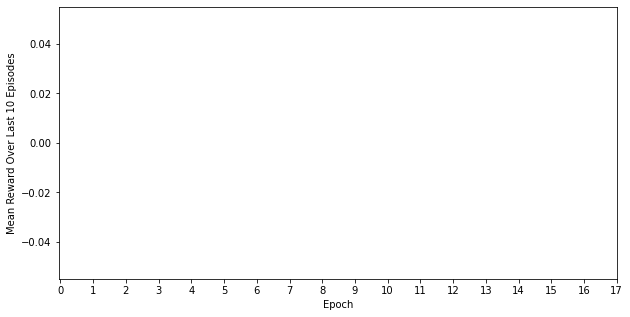

In [45]:
# Plot Results

EPISODES_PER_EPOCH = 9

average_rewards = [np.mean(episode_rewards[i - EPISODES_PER_EPOCH : i]) for i in range(len(episode_rewards), EPISODES_PER_EPOCH, -1)]

bins = [x/10 for x in range(len(average_rewards))] 
plt.figure(figsize=(10, 5))
plt.plot(bins, average_rewards)

plt.xticks(list(range(0, 18)))
plt.xlabel("Epoch")
plt.ylabel("Mean Reward Over Last 10 Episodes")
plt.show()